## Text Extraction

##### Author: Alex Sherman | alsherman@deloitte.com


Agenda:
- Docx
- PyPDF2
- PdfMiner.six
- PyMuPDF
- PdfPlumber
- PyTesseract
- python-pptx

In [4]:
import os
from IPython.display import Image
from IPython.core.display import display, HTML
from configparser import ConfigParser, ExtendedInterpolation
import zipfile
import lxml
import subprocess
import docx
from bs4 import BeautifulSoup
import pandas as pd
import PyPDF2

In [5]:
# conda install -c anaconda pywin32
import win32com.client

# conda install -c conda-forge pdfminer.six
from io import StringIO
from pdfminer.pdfpage import PDFPage
from pdfminer.layout import LAParams
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter, resolve1
from pdfminer.converter import TextConverter
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument

# pip install PyMuPDF
import fitz

# pip install pdfplumber
import pdfplumber

# pip install pytesseract 
from PIL import Image as Img
import pytesseract

# pip install python-pptx
from pptx import Presentation

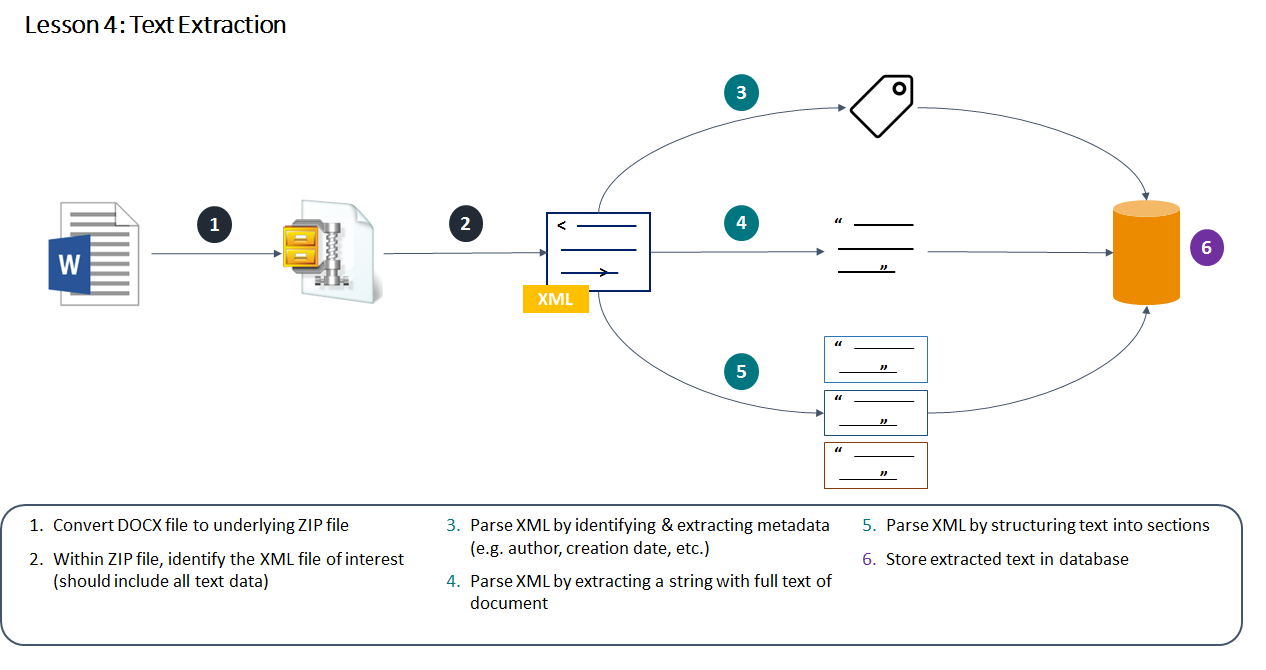

In [6]:
Image("../../raw_data/images/lesson4_text_extraction.png", width=800, height=700)

In [7]:
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

PDF_NAME = config['TEXT_EXTRACTION']['PDF_NAME']
DOCX_PATH = config['TEXT_EXTRACTION']['DOCX_PATH']
XML_PATH = config['TEXT_EXTRACTION']['XML_PATH']
EXTRACT_PATH = config['TEXT_EXTRACTION']['EXTRACT_PATH']
EXAMPLE_ZIP = config['TEXT_EXTRACTION']['EXAMPLE_ZIP']
EXAMPLE_PDF = config['TEXT_EXTRACTION']['EXAMPLE_PDF']
PDFMINER = config['TEXT_EXTRACTION']['PDFMINER']
IMAGE_MAGICK_PATH = config['TEXT_EXTRACTION']['IMAGE_MAGICK_PATH']
TESSERACT_EXE_PATH = config['TEXT_EXTRACTION']['TESSERACT_EXE_PATH']
TESSERACT_DATA_PATH = config['TEXT_EXTRACTION']['TESSERACT_DATA_PATH']

In [8]:
XML_PATH

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_cohort3\\raw_data\\docx_example.zip'

### python-docx

python-docx is a Python library for creating, updating, and extracting text from Microsoft Word (.docx) files.

In [9]:
sqlalchemy_url = 'https://python-docx.readthedocs.io/en/latest/'
iframe = '<iframe src={} width=1100 height=800></iframe>'.format(sqlalchemy_url)
HTML(iframe)

C:\Users\alsherman\AppData\Local\Continuum\miniconda3\envs\nlp\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [10]:
# the Document method reads the text, style, and formatting of a word .docx document
import docx
doc = docx.Document(DOCX_PATH)

In [11]:
# view the methods and attributes of a doc
print(dir(doc))

['_Document__body', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_block_width', '_body', '_element', '_parent', '_part', 'add_heading', 'add_page_break', 'add_paragraph', 'add_picture', 'add_section', 'add_table', 'core_properties', 'element', 'inline_shapes', 'paragraphs', 'part', 'save', 'sections', 'settings', 'styles', 'tables']


### Paragraphs

Word paragraphs contain the text of the document. However, the table text, headers, footers, are not included in paragraphs.

In [12]:
# get all paragraphs 
paragraphs = doc.paragraphs

In [13]:
# view the docx paragraph objects
paragraphs[0:5]

In [14]:
# count all paragraphs in the document
len(paragraphs)

2579

In [15]:
# only include with text (ignore empty strings)
paragraphs = [p for p in paragraphs if p.text.strip() != '']

In [16]:
# view the text of the first paragraph
paragraphs[0].text

'SOUTHWEST AIRLINES CO.'

### Style

In [17]:
# view the methods and attributes of a paragraph
print(dir(paragraphs[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_element', '_insert_paragraph_before', '_p', '_parent', 'add_run', 'alignment', 'clear', 'insert_paragraph_before', 'paragraph_format', 'part', 'runs', 'style', 'text']


In [18]:
# get the paragraph style
paragraphs[0].style.name

'Normal'

In [19]:
# Identify if paragraph text has 'Heading' style
'heading' in paragraphs[0].style.name.lower()

False

In [20]:
# view all the heading styles in the doc
set(p.style.name for p in paragraphs if 'heading' in p.style.name.lower())

{'Heading 1', 'Heading 2'}

### Exercise
 1. count how many paragraphs have a heading style
 2. store the text of all the paragraphs with a heading style

In [21]:
# store all heading paragraphs


### Runs

Each paragraph may contain one or more runs. A run denotes the style attached to the text in a paragraph. Every time the style change (e.g. from bold to normal text) a new run is added.

In [22]:
runs = paragraphs[0].runs
runs

In [23]:
# View all the runs in the paragraph
[run.text for run in runs]

['', '', 'SOUTHWEST AIRLINES CO.']

In [24]:
# each run contains a portion of text from the paragraph
run = runs[2]
run.text

'SOUTHWEST AIRLINES CO.'

### Run style

- Each run contains style information such as bold, italic, or underline. 
- The style information will be True, False, or None
- A value of None indicates the run has no directly-applied style value and so will inherit the value of its containing paragraph.

In [25]:
# view the methods and attributes of a run
print(dir(run))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_element', '_parent', '_r', 'add_break', 'add_picture', 'add_tab', 'add_text', 'bold', 'clear', 'element', 'font', 'italic', 'part', 'style', 'text', 'underline']


In [26]:
# font size
run.font.size.pt

12.0

In [27]:
print(run.bold)

True


In [28]:
print(run.italic)

None


In [29]:
print(run.underline)

None


In [30]:
# View all the run stlye 
[run.bold for run in runs]

[None, None, True]

## Exercise

#### Find all the bold runs

- Iterate through all the runs in all the paragraphs to identify any run with a bold style applied.
- Store all the bold text in a list named bold_text
- Do not include empty strings (e.g. '') 
- print the first 10 items in bold_text

In [31]:
# TODO


### Create a function to determine if all runs in a paragraph are bold

- Name the function is_bold
- Return True if all runs (with text) in a paragraph are bold
- Test the function by adding all the bold paragraphs to a list named bold_paragraphs
- Print the first 10 paragraphs in bold_paragraphs

In [32]:
# create the function is_bold
def is_bold(paragraph):
    pass
    # TODO

In [33]:
# test the is_bold function
bold_paragraphs = []
for paragraph in paragraphs:
    if is_bold(paragraph):
        bold_paragraphs.append(paragraph.text)

bold_paragraphs[0:10]

[]

### Tables

In [34]:
# identify all document tables
tables = doc.tables

In [35]:
# view a few table objects
tables[0:5]

In [36]:
# count the document tables
len(tables)

58

In [37]:
# view the methods and attributes of a table
print(dir(tables[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cells', '_column_count', '_element', '_parent', '_tbl', '_tblPr', 'add_column', 'add_row', 'alignment', 'autofit', 'cell', 'column_cells', 'columns', 'part', 'row_cells', 'rows', 'style', 'table', 'table_direction']


In [38]:
# view the cells of a table

table_cells = [cell.text.strip() for cell in tables[0]._cells if cell.text != '']
table_cells[0:10]

['PART I',
 'Item 1.',
 'Business',
 '1',
 'Item 1A.',
 'Risk Factors',
 '22',
 'Item 1B.',
 'Unresolved Staff Comments',
 '30']

### Core Properties

In [39]:
print(dir(doc.core_properties))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_element', 'author', 'category', 'comments', 'content_status', 'created', 'identifier', 'keywords', 'language', 'last_modified_by', 'last_printed', 'modified', 'revision', 'subject', 'title', 'version']


In [40]:
doc.core_properties.title

'Southwest Airlines Co. 2016 Annual Report'

In [41]:
doc.core_properties.subject

''

In [42]:
doc.core_properties.author

''

In [43]:
doc.core_properties.created

datetime.datetime(2018, 1, 3, 22, 53, 10)

In [44]:
doc.core_properties.revision

0

## Explore docx xml
Every word document is a zip of xml files. To test this, change the extension of any word file from .docx to .xml. 

Inside each zip, a directory named word contains document.xml. This file contains all of the xml for the word document.

To open the zip we use the package zipfile

In [45]:
XML_PATH

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_cohort3\\raw_data\\docx_example.zip'

### zipfile

ZipFile - The class for reading and writing ZIP files
read - Returns the bytes content from a zipfile

In [46]:
zipfile_url = 'https://docs.python.org/2/library/zipfile.html#zipfile-objects'
iframe = '<iframe src={} width=1100 height=300></iframe>'.format(zipfile_url)
HTML(iframe)

In [47]:
import zipfile

zipf = zipfile.ZipFile(XML_PATH, 'r')

In [48]:
for f in zipf.filelist:
    print(f.filename)

[Content_Types].xml
_rels/.rels
word/_rels/document.xml.rels
word/document.xml
word/theme/theme1.xml
word/settings.xml
word/fontTable.xml
word/webSettings.xml
docProps/app.xml
docProps/core.xml
word/styles.xml


In [49]:
xml_content = zipf.read('word/document.xml')

In [50]:
from bs4 import BeautifulSoup

b = BeautifulSoup(xml_content, 'lxml')

In [51]:
# view the xml from a short document with one heading and one sentence
for word in b.find('w:body'):
    print(word)
    print()

<w:p w:rsidp="00A96863" w:rsidr="007F6AD8" w:rsidrdefault="00A96863"><w:ppr><w:pstyle w:val="Heading1"></w:pstyle></w:ppr><w:r><w:t>Section Header</w:t></w:r></w:p>

<w:p w:rsidr="00A96863" w:rsidrdefault="00A96863"><w:r><w:t>Text in the section</w:t></w:r><w:bookmarkstart w:id="0" w:name="_GoBack"></w:bookmarkstart><w:bookmarkend w:id="0"></w:bookmarkend></w:p>

<w:sectpr w:rsidr="00A96863"><w:pgsz w:h="15840" w:w="12240"></w:pgsz><w:pgmar w:bottom="1440" w:footer="720" w:gutter="0" w:header="720" w:left="1440" w:right="1440" w:top="1440"></w:pgmar><w:cols w:space="720"></w:cols><w:docgrid w:linepitch="360"></w:docgrid></w:sectpr>



### docx XML tag definitions
- < w:body > - contains the document paragraphs
- < w:p > - Document paragraph
- < w:pstyle > Document Style (e.g. Header 1)
- < w:t > text in a paragraph or run
- < w:bookmarkstart > defines a bookmark, such as a link in a table of contents
- < w:r > - Document runs. Every time the style in a paragraph changes, for instance a bold or underline term, a new run is added. Each paragraph may contain multiple runs.


In [52]:
# view the lesson3 directory - notice there is no 'word' directory
%ls

 Volume in drive C is OSDisk
 Volume Serial Number is 1E90-A1EF

 Directory of C:\Users\alsherman\Desktop\NLP\nlp_practicum_cohort3\lessons\lesson_1_text_extraction

05/28/2019  12:58 AM    <DIR>          .
05/28/2019  12:58 AM    <DIR>          ..
05/20/2019  10:37 PM    <DIR>          .ipynb_checkpoints
05/24/2019  08:39 PM           220,848 page-0.png
05/24/2019  08:39 PM           457,863 page-highquality-0.png
05/27/2019  11:29 PM    <DIR>          raw_data
05/28/2019  12:58 AM           146,075 text_extraction_lesson.ipynb
05/23/2019  12:09 AM            10,304 text_extraction_solution.ipynb
05/13/2019  10:33 PM    <DIR>          word
               4 File(s)        835,090 bytes
               5 Dir(s)  115,490,205,696 bytes free


C:\Users\alsherman\AppData\Local\Continuum\miniconda3\envs\nlp\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\alsherman\AppData\Local\Continuum\miniconda3\envs\nlp\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
C:\Users\alsherman\AppData\Local\Continuum\miniconda3\envs\nlp\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


In [53]:
# Extract a member from the archive to the current working directory
zipf.extract('word/document.xml')

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_cohort3\\lessons\\lesson_1_text_extraction\\word\\document.xml'

In [54]:
# view the lesson3 directory with a 'word' directory
%ls

 Volume in drive C is OSDisk
 Volume Serial Number is 1E90-A1EF

 Directory of C:\Users\alsherman\Desktop\NLP\nlp_practicum_cohort3\lessons\lesson_1_text_extraction

05/28/2019  12:58 AM    <DIR>          .
05/28/2019  12:58 AM    <DIR>          ..
05/20/2019  10:37 PM    <DIR>          .ipynb_checkpoints
05/24/2019  08:39 PM           220,848 page-0.png
05/24/2019  08:39 PM           457,863 page-highquality-0.png
05/27/2019  11:29 PM    <DIR>          raw_data
05/28/2019  12:58 AM           146,075 text_extraction_lesson.ipynb
05/23/2019  12:09 AM            10,304 text_extraction_solution.ipynb
05/13/2019  10:33 PM    <DIR>          word
               4 File(s)        835,090 bytes
               5 Dir(s)  115,490,201,600 bytes free


### Exercise

In this exercise, we will search through several Oracle annual reports to find selected text throughout all the documents without needing to extract the files from the zip manually. 

In [55]:
EXAMPLE_ZIP

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_cohort3\\raw_data\\oracle-corporation.zip'

In [56]:
# use zipfile to read the EXAMPLE_ZIP


In [57]:
# How many documents are in the provided zip?


In [58]:
# view the filenames
# use the .filename attribute on each file in zip.filelist



In [59]:
# Find the five paragraphs scattered in all the documents in the zip
# that speak about 'Financial Accounting Standards No. 109'

# iterate through the filelist

    # use zip.extract the file to the currect working directory
    
    # open the document with docx
    
    # iterate through the paragraphs in the document
    
        # check which paragraphs contain 'Financial Accounting Standards No. 109'
        # if 'Financial Accounting Standards No. 109' in p.text:
            
            # print the paragraphs that meet the condition
            

### DOC (old version of DOCX)

##### INSTALLATION: 
conda install -c anaconda pywin32

In [60]:
import win32com.client

In [61]:
# open and extract the text from a word .doc file
word = win32com.client.gencache.EnsureDispatch('Word.Application')
doc = word.Documents.Open(DOCX_PATH, Visible=False)
text = doc.Range().Text

In [62]:
text[0:500].replace('\r', ' ')

'/  SOUTHWEST AIRLINES CO. 2016 ANNUAL REPORT TO SHAREHOLDERS To our Shareholders:  Following record years in 2014 and 2015, 2016 was another record year. It is remarkable that we were able to sustain, and in some cases, improve upon the dramatic results achieved in 2015. The foundation was laid with strategic initiatives that transformed Southwest during the five years ended 2014. Our results were further boosted by the significant reduction in energy prices, generally range-bound in the $45-$55'

In [63]:
# determine the number of pages in a word doc
doc.Repaginate()
num_pages = doc.ComputeStatistics(2)

num_pages

142

##### Office VBA Reference
https://docs.microsoft.com/en-us/office/vba/api/word.document.computestatistics

# PDF Text Extraction

### PyPDF2

In [64]:
import PyPDF2

In [65]:
# open the pdf
pdfFileObj = open(EXAMPLE_PDF, 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

##### PyPDF2 - MetaData

In [66]:
# view the number of pages in the pdf
num_pages = pdfReader.numPages
num_pages

142

In [67]:
# view the document metadata
doc_info = pdfReader.getDocumentInfo()
doc_info

{'/CreationDate': "D:20170331175931-04'00'",
 '/Producer': 'Acrobat Distiller 8.1.0 (Windows)',
 '/ModDate': "D:20170416182048+05'30'",
 '/Title': 'Southwest Airlines Co. 2016 Annual Report'}

In [68]:
# extract the title
doc_info['/Title']

'Southwest Airlines Co. 2016 Annual Report'

In [69]:
# extract the creation date
doc_info['/CreationDate']

"D:20170331175931-04'00'"

##### PyPDF2 - PDF Text

In [70]:
# extract text from pdf
full_text = []
for page in range(pdfReader.numPages):
    pageObj = pdfReader.getPage(page)
    text = pageObj.extractText().strip().replace('\n',' ')
    full_text.append(text)

In [71]:
full_text[0]

'SOUTHWESTAIRLINESCO. 2016ANNUALREPORTTOSHAREHOLDERS ToourShareholders: Followingrecordyearsin2014and2015,2016wasanotherrecordyear.Itis remarkablethatwewereabletosustain,andinsomecases,improveuponthedramatic  resultsachievedin2015.Thefoundationwaslaidwithstrategicinitiativesthat  transformedSouthwestduringthefiveyearsended2014.Ourresultswerefurther  boostedbythesignificantreductioninenergyprices,generallyrange-boundinthe  $45-$55abarrelrangeforBrentcrudeoil.Theresultwasanotheryearofrecordtraffic,  recordloadfactors,recordrevenues,recordprofits,andarecordyear-endstockprice  (LUV).Forthesecondyearinarow,andforonlythesecondtimeinourhistory,our  annualpre-taxreturnoninvestedcapital(ROIC) 1was30percentorbetter.Itwasour44 thconsecutiveyearofprofitability,arecordunmatchedinthedomesticairlineindustry,and  acontinueddisplayofourleadershipincorporateAmerica. Our2016netincomewasarecord$2.24billion,or$3.55perdilutedshare,2.9 percentand8.6percenthigherthan2015,respectively.Excludingspecialitems 1,o

### pdfminer.six

##### Installation
- conda install -c conda-forge pdfminer.six

"PDFMiner is a tool for extracting information from PDF documents. Unlike other PDF-related tools, it focuses entirely on getting and analyzing text data. PDFMiner allows one to obtain the exact location of text in a page, as well as other information such as fonts or lines. It includes a PDF converter that can transform PDF files into other text formats (such as HTML). It has an extensible PDF parser that can be used for other purposes than text analysis."

"The PDFMiner library excels at extracting data and coordinates from a PDF. In most cases, you can use the included command-line scripts to extract text and images (pdf2txt.py) or find objects and their coordinates (dumppdf.py). If you're dealing with a particularly nasty PDF and you need to get more detailed , you can import the package and use it as library.

The pdf2txt.py command: 
- The package includes the pdf2txt.py command-line command, which you can use to extract text and images. The command supports many options and is very flexible. Some popular options are shown below. See the usage information for complete details.

**pdf2txt.py [options] filename.pdf**

Options:
- o output file name
- p comma-separated list of page numbers to extract
- t output format (text/html/xml/tag[for Tagged PDFs])
- O dirname (triggers extraction of images from PDF into directory)
- P password

Source: https://www.binpress.com/tutorial/manipulating-pdfs-with-python/167

In [72]:
from io import StringIO
from pdfminer.pdfpage import PDFPage
from pdfminer.layout import LAParams
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter, resolve1
from pdfminer.converter import TextConverter
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument

In [73]:
# open a connection to the pdf

pdf = open(EXAMPLE_PDF, 'rb')
parser = PDFParser(pdf)
document = PDFDocument(parser)

In [74]:
# instantiate pdfminer components for text extraction

rsrcmgr = PDFResourceManager()
retstr = StringIO()
laparams = LAParams()
device = TextConverter(rsrcmgr, retstr, laparams=laparams)
interpreter = PDFPageInterpreter(rsrcmgr, device)

In [75]:
# check if document allows extraction

if not document.is_extractable:
    print('PDF does not allow extraction: .is_extractable attribute is false')

In [76]:
# extract and store the text from the provided page range or entire document

text = []
for page_num, page in enumerate(PDFPage.create_pages(document)):
    interpreter.process_page(page)
    text.append(retstr.getvalue())

In [77]:
# close connections

pdf.close()
device.close()
retstr.close()

In [78]:
' '.join(text)[0:500]

'SOUTHWEST AIRLINES CO.\n\n2016 ANNUAL REPORT TO SHAREHOLDERS\n\nTo our Shareholders:\n\nFollowing record years in 2014 and 2015, 2016 was another record year. It is\n\nremarkable that we were able to sustain, and in some cases, improve upon the dramatic\nresults achieved in 2015. The foundation was laid with strategic initiatives that\ntransformed Southwest during the five years ended 2014. Our results were further\nboosted by the significant reduction in energy prices, generally range-bound in the\n$45-$55'

In [79]:
# get page count in the pdf
resolve1(document.catalog['Pages'])['Count']

142

##### subprocess - use python to interact with the command line

"The subprocess module allows you to spawn new processes, connect to their input/output/error pipes, and obtain their return codes"

**subprocess.check_output()**
- Run command with arguments and return its output.
- If the return code was non-zero it raises a CalledProcessError. The CalledProcessError object will have the return code in the returncode attribute and any output in the output attribute.

**subprocess.call**
- Run the command described by args. Wait for command to complete, then return the returncode attribute.

SOURCE: https://docs.python.org/3/library/subprocess.html

In [80]:
# run an ls from python
import subprocess
output = subprocess.check_output('ls', shell=True)
print(output.split())

[b'page-0.png', b'page-highquality-0.png', b'raw_data', b'text_extraction_lesson.ipynb', b'text_extraction_solution.ipynb', b'word']


In [81]:
# view example pdf in raw_data dir to extract text from using pdfminer.six
output = subprocess.check_output(['ls','raw_data'], shell=True)
output.split()

[b'docx_example.zip',
 b'southwest-airlines-co_annual_report_2016.docx',
 b'southwest-airlines-co_annual_report_2016.pdf']

In [82]:
pdfminer_six_extract_path = os.path.join(EXTRACT_PATH, 'southwest_2016.txt')
pdfminer_six_extract_path

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_cohort3\\raw_data\\southwest-airlines-co\\extract\\southwest_2016.txt'

In [83]:
# Note - you may need to change this path if you are using anaconda or have a global install path
PDFMINER

'C:\\Users\\alsherman\\AppData\\Local\\Continuum\\miniconda3\\envs\\nlp\\Scripts\\pdf2txt.py'

In [84]:
# extract the first three pages of the pdf, output to a .txt 
cmd = [
    'python'
  , PDFMINER
  , EXAMPLE_PDF
  , '-o'  # output file name
  , pdfminer_six_extract_path
  , '-t'  # output format
  , 'text'
  , '-p'  # pages to extract, default is to extract all pages
  , '1,2,3'  # only extract a few pages for the example 
]

subprocess.call(cmd, shell=True) 

0

### PyMuPDF


PyMuPDF is a Python binding for MuPDF – “a lightweight PDF and XPS viewer”.

MuPDF stands out among all similar products for its top rendering capability and unsurpassed processing speed. At the same time, its “light weight” makes it an excellent choice for platforms where resources are typically limited, like smartphones.

##### INSTALLATION 

pip install PyMuPDF


##### License:

PyMuPDF is distributed under GNU GPL V3 (or later, at your choice).

MuPDF is distributed under a separate license, the GNU AFFERO GPL V3.

Both licenses apply, when you use PyMuPDF.

Note: Version 3 of the GNU AFFERO GPL is a lot less restrictive than its earlier versions used to be. It basically is an open source freeware license, that obliges your software to also being open source and freeware.

SOURCES: 
- https://pymupdf.readthedocs.io/en/latest/intro/
- https://pymupdf.readthedocs.io/en/latest/tutorial/
- https://www.mupdf.com/

In [85]:
import fitz

In [86]:
print(fitz.__doc__)

PyMuPDF 1.14.15: Python bindings for the MuPDF 1.14.0 library,
built on 2019-05-22 14:26:15


In [87]:
# load a document
doc = fitz.open(EXAMPLE_PDF)

The following file types are supported as input to construct pixmaps: BMP, JPEG, GIF, TIFF, JXR, JPX, PNG, PAM and all of the Portable Anymap family (PBM, PGM, PNM, PPM). This support is two-fold:

In [88]:
# view metadata dict
doc.metadata

{'format': 'PDF 1.3',
 'title': 'Southwest Airlines Co. 2016 Annual Report',
 'author': None,
 'subject': None,
 'keywords': None,
 'creator': None,
 'producer': 'Acrobat Distiller 8.1.0 (Windows)',
 'creationDate': "D:20170331175931-04'00'",
 'modDate': "D:20170416182048+05'30'",
 'encryption': None}

##### Extract Text

In [89]:
# view the text of a selected page

page = doc.loadPage(0)
page.getText()

'SOUTHWEST AIRLINES CO.\n2016 ANNUAL REPORT TO SHAREHOLDERS\nTo our Shareholders:\nFollowing record years in 2014 and 2015, 2016 was another record year. It is\nremarkable that we were able to sustain, and in some cases, improve upon the dramatic\nresults achieved in 2015. The foundation was laid with strategic initiatives that\ntransformed Southwest during the five years ended 2014. Our results were further\nboosted by the significant reduction in energy prices, generally range-bound in the\n$45-$55 a barrel range for Brent crude oil. The result was another year of record traffic,\nrecord load factors, record revenues, record profits, and a record year-end stock price\n(LUV). For the second year in a row, and for only the second time in our history, our\nannual pre-tax return on invested capital (ROIC)1 was 30 percent or better. It was our 44th\nconsecutive year of profitability, a record unmatched in the domestic airline industry, and\na continued display of our leadership in corpora

In [90]:
# view the text as a dict with x,y coordinate data
page.getText("dict")['blocks'][1] # increment ind to see more text

{'type': 0,
 'bbox': (168.05039978027344,
  98.93201446533203,
  426.0203857421875,
  124.72000885009766),
 'lines': [{'wmode': 0,
   'dir': (1.0, 0.0),
   'bbox': (216.60000610351562,
    98.93201446533203,
    377.3376159667969,
    112.72000885009766),
   'spans': [{'size': 12.0,
     'flags': 20,
     'font': 'ArialMT-Bold',
     'text': 'SOUTHWEST AIRLINES CO.'}]},
  {'wmode': 0,
   'dir': (1.0, 0.0),
   'bbox': (168.05039978027344,
    110.93201446533203,
    426.0203857421875,
    124.72000885009766),
   'spans': [{'size': 12.0,
     'flags': 20,
     'font': 'ArialMT-Bold',
     'text': '2016 ANNUAL REPORT TO SHAREHOLDERS'}]}]}

In [91]:
# view font aligned with text
for text in page.getText("dict")['blocks'][1:]:
    print(text['lines'][0]['spans'][0]['font'])
    print(text['lines'][0]['spans'][0]['text'], '\n')

ArialMT-Bold
SOUTHWEST AIRLINES CO. 

ArialMT
To our Shareholders: 

ArialMT
Following record years in 2014 and 2015, 2016 was another record year. It is 

ArialMT
consecutive year of profitability, a record unmatched in the domestic airline industry, and 

ArialMT
Our 2016 net income was a record $2.24 billion, or $3.55 per diluted share, 2.9 

ArialMT
Total operating revenues topped $20 billion for the first time, up 3.1 percent 

ArialMT
We were not planning to add any new cities in 2016; however, as I reported in last 

Times-Roman
1 



##### Table of Contents

This will return a Python list of lists [[lvl, title, page, ...], ...] which looks much like a conventional table of contents found in books.

lvl is the hierarchy level of the entry (starting from 1), title is the entry’s title, and page the page number (1-based!). Other parameters describe details of the bookmark target.

In [92]:
table_of_contents = doc.getToC()
pd.DataFrame(table_of_contents, columns=['lvl','title','page'])

,lvl,title,page
0,1,FIRST PAGE,1
1,1,TO OUR SHAREHOLDERS,1
2,1,FORM 10-K,5
3,2,Table of Contents\r,6
4,2,Part I\r,7
5,3,Item 1. Business,7
6,3,Item 1A. Risk Factors,28
7,3,Item 1B. Unresolved Staff Comments,36
8,3,Item 2. Properties,37
9,3,Item 3. Legal Proceedings,38


##### Convert Formats (PDF --> IMG)

In [93]:
EXTRACT_PATH

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_cohort3\\raw_data\\southwest-airlines-co\\extract'

In [94]:
# convert one pdf page to an image
pix = page.getPixmap()
pix.writePNG("page-0.png")

In [95]:
%%time

# convert all pdf pages to images
doc = fitz.open(EXAMPLE_PDF)
for page in doc:
    
    # render page to an image
    pix = page.getPixmap(alpha = False)
    
    # path to store images
    extract_path = os.path.join(EXTRACT_PATH, f"page-{page.number}.png")

    # store image as a PNG
    pix.writePNG(extract_path)

Wall time: 8.06 s


In [96]:
# High Quality Export
# In the following, we apply a zoom factor of 2 to each dimension, 
# which will generate an image with a four times better resolution for us.

zoom_x = 2.0                       # horizontal zoom
zomm_y = 2.0                       # vertical zoom
mat = fitz.Matrix(zoom_x, zomm_y)  # zoom factor 2 in each dimension
pix = page.getPixmap(matrix = mat) # use 'mat' instead of the identity matrix
pix.writePNG(f"page-highquality-0.png")  # store image as a PNG

##### Performance Tips

If you do not need images extracted alongside the text of a page, you can set the following option:

This will save ca. 25% overall execution time for the HTML, XHTML and JSON text extractions and hugely reduce the amount of storage (both, memory and disk space) if the document is graphics oriented.


In [97]:
dl = page.getDisplayList()
flags = fitz.TEXT_PRESERVE_LIGATURES | fitz.TEXT_PRESERVE_WHITESPACE
tp = dl.getTextPage(flags)
tp.extractText()

'CORPORATE INFORMATION\nSOUTHWEST AIRLINES CO. GENERAL OFFICES\nP.O. Box 36611\n2702 Love Field Drive\nDallas, TX 75235\nTelephone: 214-792-4000\nFINANCIAL INFORMATION\nA copy of the Company’\ns Annual Report on Form 10-K, as\nfiled with the U.S. Securities and Exchange Commission, is\nincluded herein. Other financial information can be found on\nSouthwest’\ns web site (southwest.com) or may be obtained\nwithout charge by writing or calling:\nSouthwest Airlines Co.\nInvestor Relations, HDQ-6IR\nP.O. Box 36611\n2702 Love Field Drive\nDallas, Texas 75235\nTelephone: 214-792-4908\nANNUAL MEETING\nThe Annual Meeting of Shareholders of Southwest Airlines\nCo. will be held at 10:00 a.m. on May 17, 2017, at the\nKimpton Hotel Palomar Phoenix located at 2 East Jefferson\nStreet, Phoenix, Arizona 85004.\nSTOCK EXCHANGE LISTING\nNew York Stock Exchange Ticker Symbol: LUV\nTRANSFER AGENT AND REGISTRAR\nRegistered shareholder inquiries regarding stock transfers,\naddress changes, lost stock certif

##### Extracting Table Text

SOURCE: https://raw.githubusercontent.com/pymupdf/PyMuPDF-Utilities/master/textboxtract.py

In [98]:
"""
Script showing how to select only text that is contained in a given rectangle
on a page.

We use the page method 'getTextWords()' which delivers a list of all words.
Every item contains the word's rectangle (given by its coordinates, not as a
fitz.Rect in this case).
From this list we subselect words positioned in the given rectangle (or are at
least partially contained).
We sort this sublist by ascending y-ccordinate, and then by ascending x value.
Each original line of the rectangle is then reconstructed using the itertools
'groupby' function.

Remarks
-------
1. The script puts words in the same line, if the y1 value of their bbox are
   *exactly* equal. Allowing some tolerance here is imaginable, e.g. by
   taking the fitz.IRect of the word rectangles instead.

2. Reconstructed lines will contain words with exactly one space between them.
   So any original multiple spaces will be ignored.
"""
from operator import itemgetter 
from itertools import groupby
import fitz
doc = fitz.open(EXAMPLE_PDF)     # any supported document type
page = doc[9]                    # we want text from this page

"""
-------------------------------------------------------------------------------
Identify the rectangle. We use the text search function here. The two
search strings are chosen to be unique, to make our case work.
The two returned rectangle lists both have only one item.
-------------------------------------------------------------------------------
"""
rl1 = page.searchFor("can") # rect list one
rl2 = page.searchFor("through fleet")       # rect list two
rect = rl1[0] | rl2[0]       # union rectangle
# Now we have the rectangle ---------------------------------------------------

"""
Get all words on page in a list of lists. Each word is represented by:
[x0, y0, x1, y1, word, bno, lno, wno]
The first 4 entries are the word's rectangle coordinates, the last 3 are just
technical info (block number, line number, word number).
"""
words = page.getTextWords()
# We subselect from above list.

# Case 1: select the words fully contained in rect
#------------------------------------------------------------------------------
mywords = [w for w in words if fitz.Rect(w[:4]) in rect]
mywords.sort(key = itemgetter(3, 0))   # sort by y1, x0 of the word rect
group = groupby(mywords, key = itemgetter(3))
print("Select the words strictly contained in rectangle")
print("------------------------------------------------")
for y1, gwords in group:
    print(" ".join(w[4] for w in gwords))

# Case 2: select the words which at least intersect the rect
#------------------------------------------------------------------------------
mywords = [w for w in words if fitz.Rect(w[:4]).intersects(rect)]
mywords.sort(key = itemgetter(3, 0))
group = groupby(mywords, key = itemgetter(3))
print("\nSelect the words intersecting the rectangle")
print("-------------------------------------------")
for y1, gwords in group:
    print(" ".join(w[4] for w in gwords))

Select the words strictly contained in rectangle
------------------------------------------------
can fluctuate significantly in a relatively short amount of time. The table below shows the Company’ s
average cost of jet fuel for each year beginning in 2003 and during each quarter of 2016.
Average Percentage of
Cost Cost Per Operating
Year (Millions) Gallon Expenses
2003 $ 920 $ 0.80 16.5%
2004 $ 1,106 $ 0.92 18.1%
2005 $ 1,470 $ 1.13 21.4%
2006 $ 2,284 $ 1.64 28.0%
2007 $ 2,690 $ 1.80 29.7%
2008 $ 3,713 $ 2.44 35.1%
2009 $ 3,044 $ 2.12 30.2%
2010 $ 3,620 $ 2.51 32.6%
2011 $ 5,644 $ 3.19 37.7%
2012 $ 6,120 $ 3.30 37.2%
2013 $ 5,763 $ 3.16 35.1%
2014 $ 5,293 $ 2.93 32.3%
2015 $ 3,616 $ 1.90 23.0%
2016 $ 3,647 $ 1.82 21.9%
First Quarter 2016 $ 852 $ 1.80 21.9%
Second Quarter 2016 $ 903 $ 1.75 22.0%
Third Quarter 2016 $ 941 $ 1.83 21.2%
Fourth Quarter 2016 $ 952 $ 1.90 22.5%
The Company focuses on reducing fuel consumption and improving fuel efficiency through fleet

Select the words inte

### PdfPlumber

PdfPlumber offers detailed information about each text character, rectangle, and line. It is useful for table extraction due to its visual debugging.

##### INSTALLATION:
1. pip install pdfplumber
2. install ImageMagick: 
    - http://docs.wand-py.org/en/latest/guide/install.html#install-imagemagick-debian
    - https://imagemagick.org/script/download.php#windows

SOURCE: https://github.com/jsvine/pdfplumber

In [99]:
import pdfplumber

In [100]:
pdf =  pdfplumber.open(EXAMPLE_PDF)
page = pdf.pages[0]
page

In [101]:
print(dir(page))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'annos', 'bbox', 'cached_properties', 'chars', 'crop', 'cropbox', 'curves', 'debug_tablefinder', 'decimalize', 'edges', 'extract_table', 'extract_tables', 'extract_text', 'extract_words', 'figures', 'filter', 'find_tables', 'flush_cache', 'height', 'horizontal_edges', 'images', 'initial_doctop', 'is_original', 'layout', 'lines', 'mediabox', 'objects', 'page_number', 'page_obj', 'parse_objects', 'pdf', 'rect_edges', 'rects', 'rotation', 'to_image', 'vertical_edges', 'width', 'within_bbox']


In [102]:
# view the first few extracted words
page.extract_text()[0:500]

'SOUTHWEST AIRLINES CO.\n2016 ANNUAL REPORT TO SHAREHOLDERS\nTo our Shareholders:\nFollowing record years in 2014 and 2015, 2016 was another record year. It is\nremarkable that we were able to sustain, and in some cases, improve upon the dramatic\nresults achieved in 2015. The foundation was laid with strategic initiatives that\ntransformed Southwest during the five years ended 2014. Our results were further\nboosted by the significant reduction in energy prices, generally range-bound in the\n$45-$55 a b'

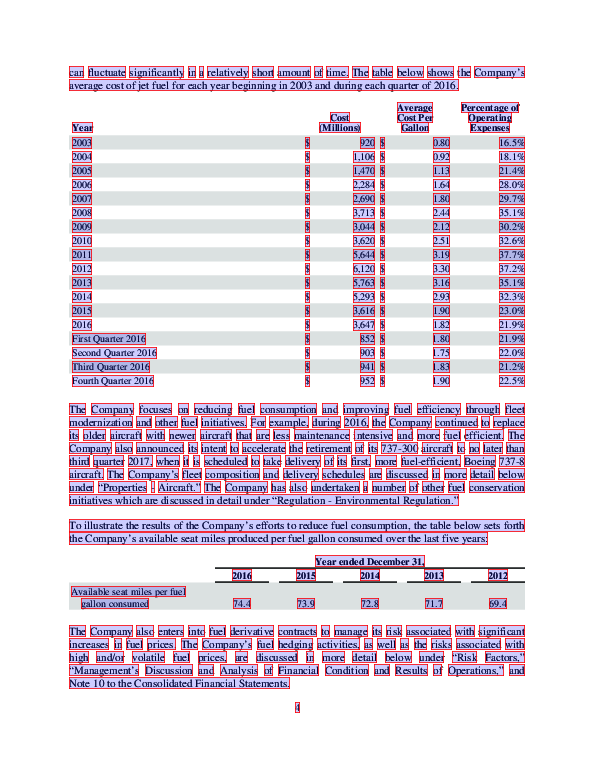

In [103]:
# view the page in the browser, with boxes highlighting what PdfPlumber sees

page = pdf.pages[9]
im = page.to_image()
im.draw_rects(page.extract_words())

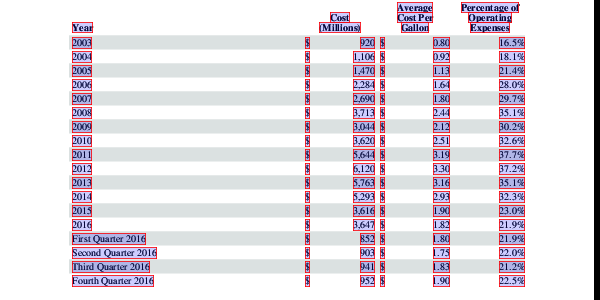

In [104]:
# Crop the page to focus on the table

# crop = (x0, top, x1, bottom)
page = pdf.pages[9].crop((0,100, 600, 400))

# view the cropped text
im = page.to_image()
im.draw_rects(page.extract_words())

In [105]:
# extract the table text
# use different table_settings to determine the table layout
# table-extraction strategies: https://github.com/jsvine/pdfplumber

data = page.extract_tables(table_settings={
    'vertical_strategy': 'text',
    'horizontal_strategy':'text'
})
pd.DataFrame(data[1:][0])

,0,1,2,3,4,5
0,2003,$,920,$,0.80,16.5%
1,2004,$,"1,106",$,0.92,18.1%
2,2005,$,"1,470",$,1.13,21.4%
3,2006,$,"2,284",$,1.64,28.0%
4,2007,$,"2,690",$,1.80,29.7%
5,2008,$,"3,713",$,2.44,35.1%
6,2009,$,"3,044",$,2.12,30.2%
7,2010,$,"3,620",$,2.51,32.6%
8,2011,$,"5,644",$,3.19,37.7%
9,2012,$,"6,120",$,3.30,37.2%


##### Python for CPAs

For more on PdfPlumber, read the below post on Daniel Shorstein's (GPS Advisory Senior Manager <dshorstein@deloitte.com>) blog - Python for CPAs 

http://www.python4cpas.com/2018/12/extracting-accounting-data-from-pdfs.html

### OCR

INSTALLATION:

##### PDF to Image conversion
- ghostscript: https://www.ghostscript.com/download/gsdnld
- ImageMagick: 
    - http://docs.wand-py.org/en/latest/guide/install.html#install-imagemagick-debian
    - https://imagemagick.org/script/download.php#windows


##### OCR 
- pytesseract (OCR): https://pypi.org/project/pytesseract
- pip install pytesseract 
- download pytesseract models: https://digi.bib.uni-mannheim.de/tesseract/tesseract-ocr-setup-3.05.02-20180621.exe

##### Convert PDF to IMAGE

In [106]:
# you must download image magick to run the below code
IMAGE_MAGICK_PATH

'C:\\Program Files\\ImageMagick-6.9.10-Q8\\convert.exe'

In [107]:
%%time

# convert the pdf to an image
cmd = [
      IMAGE_MAGICK_PATH                           # path to pdf --> image conversion software
    , '-density'                                  # density improves ocr text extraction quality
    , '300'                                       
    , '-quality'                                  # set image quality 
    , '99'
    , EXAMPLE_PDF                                 # example pdf document
    , os.path.join(EXTRACT_PATH, "extract.png")   # output directory - each page of the pdf is converted into a separate image
]

subprocess.call(cmd, shell=True) 

Wall time: 4min 44s


##### OCR Images

In [108]:
import pytesseract
from PIL import Image as Img

In [109]:
pytesseract.pytesseract.tesseract_cmd = TESSERACT_EXE_PATH  # pytesseract configuration
os.chdir(TESSERACT_DATA_PATH)                               # needed for pytesseract data files
Img.MAX_IMAGE_PIXELS = 1000000000                         # enable processing of larger images

In [110]:
def extract_text_from_images(fname, num_pages):
    """ extract and store the text by OCR'ing the images """
    
    full_text = []
    
    for i_path in yield_image_paths(f_name=fname, num_images=num_pages):
        img = Img.open(i_path)
    
        try:
            text = pytesseract.image_to_string(img)
        except pytesseract.pytesseract.TesseractError as e:
            print('ERROR - unable to process image: {}'.format(e.message))
            text = ''

        full_text.append(text.replace('\n',' '))
    
    return full_text

In [111]:
def yield_image_paths(f_name, num_images):
    """ create and yield all path to converted image files

    NOTE: if a pdf if > 1 page, then the image_magick library will create one image for each page. The image
          file names use the syntax '-{pagenumber}' at the end of the original file name to denote new files
    """

    fname = f_name.replace('.pdf', '.png')

    # single page pdf (no '-{num}' appended to image name)    
    if num_images == 1:
        yield os.path.join(EXTRACT_PATH, f_name)
        return

    # denote image_path for a specific page (e.g. page 10 of a pdf)
    for pg in range(num_images):
        png_name = '-{}.png'.format(pg).join(fname.rsplit('.png', 1))
        i_path = os.path.join(EXTRACT_PATH, png_name)
        yield i_path

In [112]:
# view image magick converted images
ocr_text = extract_text_from_images(fname='extract.pdf', num_pages=2)
ocr_text[0:500]

["Southwest-  SOUTHWEST AIRLINES CO. 2016 ANNUAL REPORT TO SHAREHOLDERS  To our Shareholders:  Following record years in 2014 and 2015, 2016 was another record year. It is remarkable that we were able to sustain, and in some cases, improve upon the dramatic results achieved in 2015. The foundation was laid with strategic initiatives that transformed Southwest during the five years ended 2014. Our results were further boosted by the significant reduction in energy prices, generally range-bound in the $45-$55 a barrel range for Brent crude oil. The result was another year of record traffic, record load factors, record revenues, record profits, and a record year-end stock price (LUV). For the second year in a row, and for only the second time in our history, our annual pre-tax return on invested capital (ROIC)' was 30 percent or better. It was our 44th consecutive year of profitability, a record unmatched in the domestic airline industry, and a continued display of our leadership in corpo

In [113]:
# view PyMuPdf converted images
ocr_text = extract_text_from_images(fname='page.pdf', num_pages=2)
ocr_text

['Southwest»  SOUTHWEST AIRLINES CO. 2016 ANNUAL REPORT TO SHAREHOLDERS:  To our Shareholders:  Following record years in 2014 and 2015, 2016 was another record year. Itis remarkable that we were able to sustain, and in Some cases, improve upon the dramatic results achieved in 2015, The foundation was laid with strategic intatives that transformed Southwest during the five years ended 2014. Our results were further boosted by the signfcant reduction in energy prices, generally range-bound inthe $45.85 a barrel range for Brent crude oil The result was another year of record traffic, record load factors, record revenues, record profits, and a record year-end stock price (LUV). For the second year in arow, and for only the second time in our history, our annual pre-ax return on invested capital (ROIC)\' was 30 percent or beter. twas our 44” consecutive year of profitability, a record unmatched inthe domestic airne industy, and  2 continued display of our leadership in corporate America  ‘

## Compare extraction methods

In [114]:
EXAMPLE_PDF

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_cohort3\\raw_data\\southwest-airlines-co\\raw_data\\southwest-airlines-co_annual_report_2016.pdf'

In [115]:
# pypdf2
full_text[0][0:500]

'SOUTHWESTAIRLINESCO. 2016ANNUALREPORTTOSHAREHOLDERS ToourShareholders: Followingrecordyearsin2014and2015,2016wasanotherrecordyear.Itis remarkablethatwewereabletosustain,andinsomecases,improveuponthedramatic  resultsachievedin2015.Thefoundationwaslaidwithstrategicinitiativesthat  transformedSouthwestduringthefiveyearsended2014.Ourresultswerefurther  boostedbythesignificantreductioninenergyprices,generallyrange-boundinthe  $45-$55abarrelrangeforBrentcrudeoil.Theresultwasanotheryearofrecordtraffic,'

In [116]:
# pdfminer
with open(pdfminer_six_extract_path, 'r', encoding='utf-8') as f:
    text = [line.replace('\n', ' ') for line in f.readlines()]

' '.join(text)[0:500]

'SOUTHWEST AIRLINES CO.    2016 ANNUAL REPORT TO SHAREHOLDERS    To our Shareholders:    Following record years in 2014 and 2015, 2016 was another record year. It is    remarkable that we were able to sustain, and in some cases, improve upon the dramatic  results achieved in 2015. The foundation was laid with strategic initiatives that  transformed Southwest during the five years ended 2014. Our results were further  boosted by the significant reduction in energy prices, generally range-bound in '

In [117]:
# PyMuPDF
doc = fitz.open(EXAMPLE_PDF)
page = doc.loadPage(0)
page.getText()[0:500].replace('\n', ' ')

'SOUTHWEST AIRLINES CO. 2016 ANNUAL REPORT TO SHAREHOLDERS To our Shareholders: Following record years in 2014 and 2015, 2016 was another record year. It is remarkable that we were able to sustain, and in some cases, improve upon the dramatic results achieved in 2015. The foundation was laid with strategic initiatives that transformed Southwest during the five years ended 2014. Our results were further boosted by the significant reduction in energy prices, generally range-bound in the $45-$55 a b'

In [118]:
# pdfplumber
pdf =  pdfplumber.open(EXAMPLE_PDF)
page = pdf.pages[0]
page.extract_text()[0:500].replace('\n', ' ')

'SOUTHWEST AIRLINES CO. 2016 ANNUAL REPORT TO SHAREHOLDERS To our Shareholders: Following record years in 2014 and 2015, 2016 was another record year. It is remarkable that we were able to sustain, and in some cases, improve upon the dramatic results achieved in 2015. The foundation was laid with strategic initiatives that transformed Southwest during the five years ended 2014. Our results were further boosted by the significant reduction in energy prices, generally range-bound in the $45-$55 a b'

In [119]:
# pytesseract ocr
ocr_text[0][0:500]

'Southwest»  SOUTHWEST AIRLINES CO. 2016 ANNUAL REPORT TO SHAREHOLDERS:  To our Shareholders:  Following record years in 2014 and 2015, 2016 was another record year. Itis remarkable that we were able to sustain, and in Some cases, improve upon the dramatic results achieved in 2015, The foundation was laid with strategic intatives that transformed Southwest during the five years ended 2014. Our results were further boosted by the signfcant reduction in energy prices, generally range-bound inthe $4'

### Python pptx

##### INSTALLATION:
pip install python-pptx

In [120]:
PPTX_PATH = r'PATH_TO_A_POWERPOINT_FILE'

In [ ]:
from pptx import Presentation

prs = Presentation(PPTX_PATH)

text = []

for slide in prs.slides:
    for shape in slide.shapes:
        if not shape.has_text_frame:
            continue
        for paragraph in shape.text_frame.paragraphs:
            for run in paragraph.runs:
                text.append(run.text)

# Additional Resources for text extraction
- Excel: https://openpyxl.readthedocs.io/en/stable/
- OCRmyPDF: https://github.com/jbarlow83/OCRmyPDF